문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 구하여 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템 만들기

1. 데이터 로드

In [1]:
# 패키지 임포트
!pip install numpy==1.20.0
!pip install gensim==3.7.0 --user
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from konlpy.tag import Okt
from io import BytesIO
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 데이터를 데이터프레임으로 로드하고, 전체 문서의 수 출력

In [3]:
import io

df = pd.read_csv('bookdata.csv')
print('전체 문서의 수 : ', len(df))

전체 문서의 수 :  61


In [4]:
# 상위 5행만 출력하여 확인

In [5]:
df[:5]

,Unnamed: 0,Unnamed: 0.1,isbn,review,cleaned,title,contents,thumbnail,authors
0,0,1,9788935668663,이책을 접하지못했다 나도 언론에서 내보이는 헤드라인으로 세상을 입력했을지도 모른다....,이책을 접하지못했다 나도 언론에서 내보이는 헤드라인으로 세상을 입력했을지도 모른다 ...,조국의 시간,"『조국의 시간』은 2019년 8월 9일, 조국이 법무부장관 후보로 지명된 이후 벌어...",https://search1.kakaocdn.net/thumb/R120x174.q8...,조국
1,1,2,9791191056556,주변에서 평이 좋아서 구매하게 된 책.\n괜히 입소문을 탄 게 아니다 싶은게 원래 ...,주변에서 평이 좋아서 구매하게 된 책 괜히 입소문을 탄 게 아니다 싶은게 원래 종...,미드나잇 라이브러리,"★ 영국 아마존 종합 베스트셀러 1위 ★ 미국 아마존, 《뉴욕타임스》, 《선데이타임...",https://search1.kakaocdn.net/thumb/R120x174.q8...,매트 헤이그
2,2,3,9791167370280,제목: 완전한 행복\n글쓴이: 정유정\n펴낸 곳: 은행나무\n 오래도록 ...,제목 완전한 행복 글쓴이 정유정 펴낸 곳 은행나무 오래도록 기다린...,완전한 행복,《내 인생의 스프링 캠프》 《내 심장을 쏴라》 《7년의 밤》 《28》 《종의 기원》...,https://search1.kakaocdn.net/thumb/R120x174.q8...,정유정
3,3,4,9791190977265,책 제목 \n - 부의 시나리오\n 나의 상황 \n - 부자 되고 싶습니다. ...,책 제목 부의 시나리오 나의 상황 부자 되고 싶습니다 ...,부의 시나리오,"오건영 저자가 불안한 금융시장 속, 흔들리는 투자자들의 다음 스텝을 지켜주기 위해 ...",https://search1.kakaocdn.net/thumb/R120x174.q8...,오건영
4,4,5,9791191347180,이 책은 트레이딩에 관한 기술적 분석을 알려준다.\n\n다른 책과의 차별성은 추세선...,이 책은 트레이딩에 관한 기술적 분석을 알려준다 다른 책과의 차별성은 추세선과 ...,매매의 기술,매매를 하다 보면 매 순간 선택의 갈림길에 놓인다. 이유는 모르지만 갑자기 매수세가...,https://search1.kakaocdn.net/thumb/R120x174.q8...,박병창


In [6]:
# 형태소 분석 하기 전 사용자 사전 추가
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.add_dictionary(list(df['authors']), 'Noun')

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [7]:
# 'Desc' 열을 대상으로 전처리를 수행하여 'cleaned'에 저장

In [8]:
def _removeNonAscii(text):
    letters_only = re.sub('[^0-9가-힣]', '', text)   
    return letters_only

def remove_stop_words(text):    
    
    twitter = Twitter()
    tokenized_data = []
    #temp_X = twitter.nouns(text) # 토큰화
    temp_X = twitter.morphs(text, stem=True) # 토큰화
    
    # 5. Stopwords 불용어 제거    
    file=open('bool.txt','r',encoding='UTF8')
    stopwords=file.readlines()[0].split(' ')
    file.close()
    
    temp_X = [word for word in temp_X if not word in stopwords] 
    tokenized_data.append(temp_X)
    return( ' '.join(temp_X) )

df['cleaned'] = df['review'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)

In [9]:
# 상위 5행만 출력하여 확인

In [10]:
df['cleaned'][:5]

0    책 접다 다나 언론 헤드라인 세상 입력 을지 도모 른다 유투브 나영 상 접 전달 체...
1    주변 평이 좋다 서구 매하 책 괜히 입 소문 다 싶다 원래 종이 책 오래 못 읽다 ...
2    제목 행복 글 쓸다 이정 유정 펴내다 곳 은행나무 오래 록기 다린 정유 정작 가의 ...
3    책 제목 부의 시나리오 상황 부자 금융 공부 필 요한 시점 지요 줄거리 요약 불 확...
4    책 트 레이 딩에관 기술적분석 준 다다 른책 과의 차별성 추세 선 과지 지선 저항 ...
Name: cleaned, dtype: object

In [11]:
# 빈 값이 있는 행 확인, nan 값으로 변환 후 해당 행 제거

In [12]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :', len(df))

전체 문서의 수 : 61


In [13]:
# 토큰화하여 corpus 라는 리스트에 저장

In [14]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

2. Word2Vec을 통해 이를 초기 단어 벡터값으로 워드 임베딩

In [15]:
model = Word2Vec(corpus, size = 300, window=5, min_count = 10, workers = -1)

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


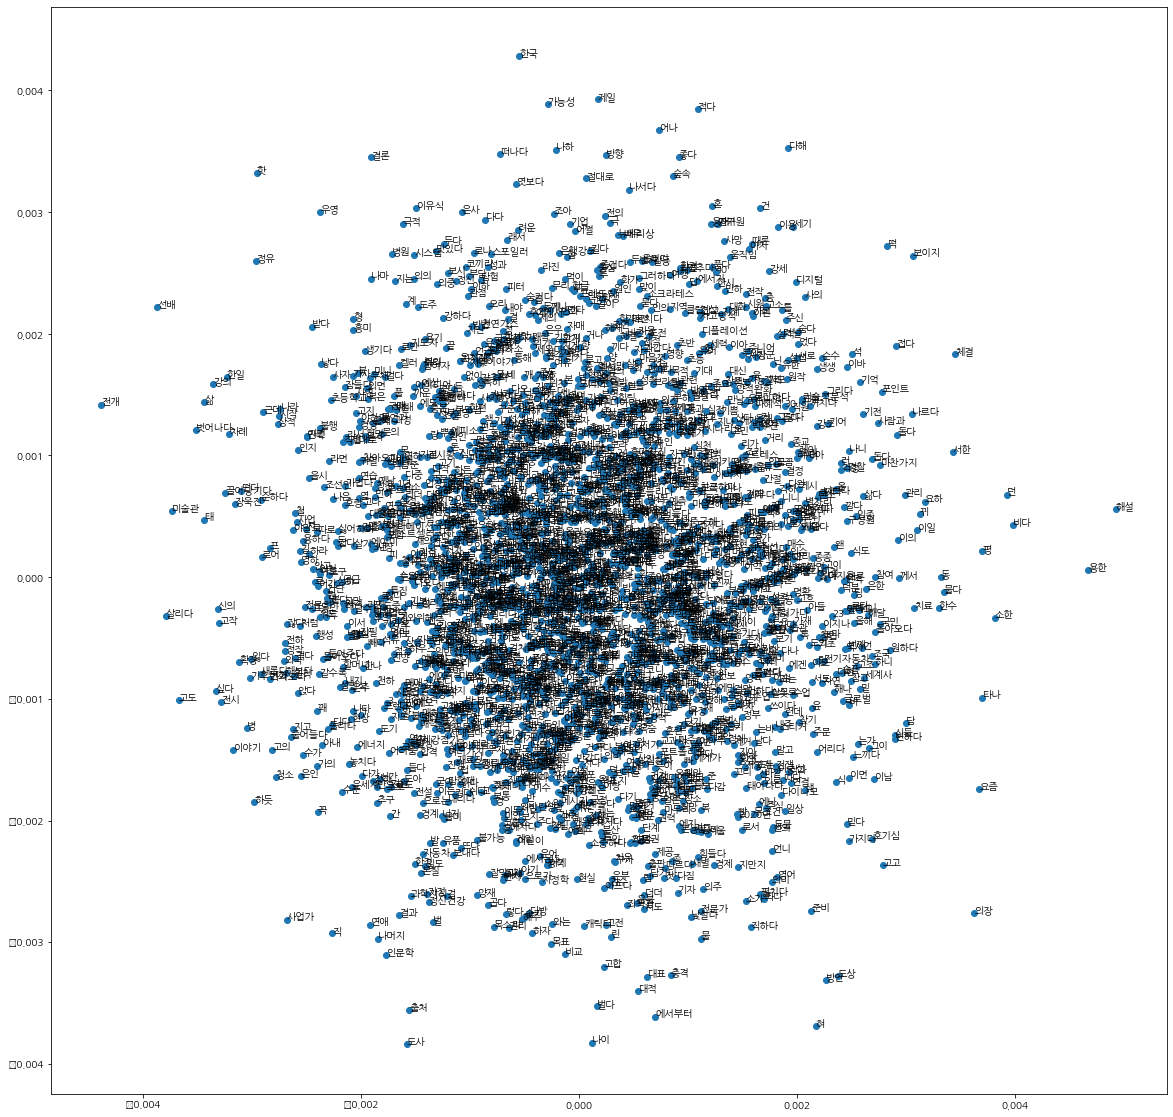

In [16]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
fm._rebuild()

plt.rc('font', family='NanumGothic')

import matplotlib.pyplot as plt

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

3. 단어 벡터의 평균 구하기

In [17]:
word2vec_model=model
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab.keys():
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list 

In [18]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

<ipython-input-17-ca7270387c53>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-17-ca7270387c53>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 61


4. 추천 시스템 구현하기

In [19]:
# 각 벡터간 코사인 유사도

cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (61, 61)


In [20]:
# 코사인 유사도를 이용하여, 가장 줄거리가 유사한 5개의 책을 찾아내는 함수 만들기

In [21]:
def recommendations(title):
    books = df[['title']]
    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates() 
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for i in book_indices:
        print(books.loc[i]['title'])

In [22]:
# 확인 : 책 제목을 입력하면 이와 유사한 책들 추천(제목, 표지)

In [23]:
recommendations('부자 아빠 가난한 아빠. 1')

더 해빙
어떻게 말해줘야 할까
부의 인문학
종의 기원
월가의 영웅


In [24]:
recommendations('어떤 죽음이 삶에게 말했다')

떠난 후에 남겨진 것들
소크라테스 익스프레스
불안한 사람들
그러라 그래
내 마음을 나도 모를 때


In [25]:
recommendations('방구석 미술관')

방구석 미술관. 2: 한국
파친코. 1
불안한 사람들
떠난 후에 남겨진 것들
아몬드


In [26]:
recommendations('내 마음을 나도 모를 때')

오은영의 화해
어떻게 말해줘야 할까
더 해빙
불안한 사람들
그러라 그래


In [27]:
recommendations('수박 수영장')

더 해빙
알사탕
시크릿
종의 기원
동의
